# Marginalizing the _full_ likelihood to obtain a _compressed_ likelihood

This notebook focuses on the semi-final product. Once we have constructed the full likelihood for a given dataset, we want to be able to marginalize over the nuisance parameters and make public an easy-to-use, compressed likelihood, for the non-experts that want to use our results.


Notation:
 - $L$ is the likelihood.
 - $\mathcal{L}$ is the log-likelihood.
 - $d$ is the data, the measured 1D power spectrum from BOSS / eBOSS / DESI / HIRES...  band powers $P_{ij}=P_{\rm 1D}(z_i, k_j)$, where $k_j$ has units of velocity ($s/km$). 
 - $\theta$ are the parameters describing the linear power spectrum.
 - $\phi$ are the nuisance parameters, describing the mean flux, temperature, pressure...
 - $\mathcal{\pi}(\phi)$ are the priors on the nuisance parameters
 
 $$ L(d | \theta) = \int d\phi \, \mathcal{\pi}(\phi) \, L(d | \theta, \phi) $$

In [1]:
%matplotlib inline
import numpy as np
import os
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import fit_pk
import lya_results

### Setup parameter space for the compressed likelihood

We will start by defining the parameter space that we want to cover for the compressed / marginalized likelihood.

For now, we will assume that there are only two parameters in the compressed likelihood, the amplitude and the slope of the linear power at $z_\star=3$ and $k_p = 0.009$ s/km. 

$$ \theta = \{ \Delta_p^2, n_p \} $$

$$ \Delta_p^2 = \frac{k_p^3}{2 \pi^2} P_L(z_\star,k_p) $$

$$ n_p = \frac{\partial \log P_L(z_\star, k)}{\partial \log(k) } $$

Based on the plot at the bottom of this notebook, we will use the following parameter space:

$$ 0.15 < \Delta_p^2 < 0.45 \qquad \qquad -2.28 < n_p < 2.40  $$

In [2]:
# range of (dimensionless) amplitudes
DL2_min=0.15
DL2_max=0.45
N_DL2=20
# range of slopes
np_min=-2.40
np_max=-2.28
N_np=20
# for annoying reasons, mgrid expects a complex number
j=1j
DL2_grid,np_grid = np.mgrid[DL2_min:DL2_max:N_DL2*j,np_min:np_max:N_np*j]

### Specify nuisance parameters

For this notebook, let us assume that we only have nuisance parameters associated to the mean flux as a function of redshift. 
The flux power spectrum for a given cosmology, at a given redshift, depends on the value of the mean flux in that redshift, $\bar{F}(z)$.

There are several parameterizations possible. If interested, take a look at the notebook mean_flux.ipynb.
 
For this notebook, we will use three parameters to describe the mean flux:
$$ \ln \tau_{\rm eff}(z) = \ln \tau_\star + n_\tau \ln \left( \frac{1+z}{1+z_\star} \right) + \alpha_\tau \ln^2 \left( \frac{1+z}{1+z_\star} \right) $$

The nuisance parameters, therefore, will be 
$$ \phi = \{ \tau_\star , n_\tau , \alpha_\tau \} $$

For now we will use top hat priors for the three nuisance parameters, roughly based on previous mean flux measurements:
$$ 0.32 < \tau_\star < 0.52  \qquad \qquad  2.5 < n_\tau < 4.5  \qquad \qquad   -3.0 < \alpha_\tau < 1.0 $$ 

In [3]:
# specify values for fiducial model of mean flux
mean_flux_model={'z_star':3.0,'tau_star_fid':0.42,'n_tau_fid':3.5,'alpha_tau_fid':-1.0}
# specify width of priors
mean_flux_model['d_tau_star']=0.1
mean_flux_model['d_n_tau']=1.0
mean_flux_model['d_alpha_tau']=2.0

In [4]:
mean_flux_model

{'alpha_tau_fid': -1.0,
 'd_alpha_tau': 2.0,
 'd_n_tau': 1.0,
 'd_tau_star': 0.1,
 'n_tau_fid': 3.5,
 'tau_star_fid': 0.42,
 'z_star': 3.0}

### Compute marginalized likelihood for every point in ($\Delta_p^2$,$n_p$) 

In a real analysis, we would probably run a MCMC for the full likelihood, and project the chains to the relevant parameter space to marginalize over nuisance parameters. If we only had two parameters, and the final posterior were fairly Gaussian, we could just use a Gaussian for our final compressed likelihood. For more parameters, or non-Gaussian scenarios, we probably need something fancier. A Gaussian mixture model?

In this notebook we'll do something simpler, and numerically integrate over the nuisance parameters, for a grid of points in our cosmological parameter space.

In [5]:
def full_loglike(DL2,n_p,tau_star,n_tau,alpha_tau,mean_flux_model):
    # here we should get a prediction from the emulator for each band power, and compare to the data
    # but for now we use a toy likelihood
    delta_chi2=lya_results.gaussian_chi2_Chabanier2019(n_p,DL2)
    delta_chi2+=((tau_star-mean_flux_model['tau_star_fid'])/0.01)**2
    delta_chi2+=((n_tau-mean_flux_model['n_tau_fid'])/0.1)**2
    delta_chi2+=((alpha_tau-mean_flux_model['alpha_tau_fid'])/0.2)**2
    return -0.5*delta_chi2

In [6]:
def marginalize_loglike(DL2,n_p,mean_flux_model):
    # here we would probably do MCMC to marginalize over nuisance parameters
    # but for now we do brute force integral, and we only marginalize over tau_star
    n_tau=mean_flux_model['n_tau_fid']
    alpha_tau=mean_flux_model['alpha_tau_fid']
    tau_star_min=mean_flux_model['tau_star_fid']-mean_flux_model['d_tau_star']
    tau_star_max=mean_flux_model['tau_star_fid']+mean_flux_model['d_tau_star']
    N_tau=20
    tau_star=np.linspace(tau_star_min,tau_star_max,N_tau)
    loglike=full_loglike(DL2,n_p,tau_star,n_tau,alpha_tau,mean_flux_model)
    likelihood=np.trapz(np.exp(loglike),tau_star)
    if False:
        print(tau_star)
        print(loglike)
        print(likelihood)
        print(DL2,n_p,np.log(likelihood))
    return np.log(likelihood)

In [7]:
marginalize_loglike(0.4,-2.33,mean_flux_model)

-14.380045182267688

In [8]:
loglike_grid = np.empty_like(DL2_grid)
for i_DL2 in range(N_DL2):
    for j_np in range(N_np):
        DL2=DL2_grid[i_DL2][j_np]
        n_p=np_grid[i_DL2][j_np]
        loglike_grid[i_DL2][j_np]=marginalize_loglike(DL2,n_p,mean_flux_model)

In [9]:
print(np.min(loglike_grid),'< loglike <',np.max(loglike_grid))

-164.787247575 < loglike < -3.76801491069


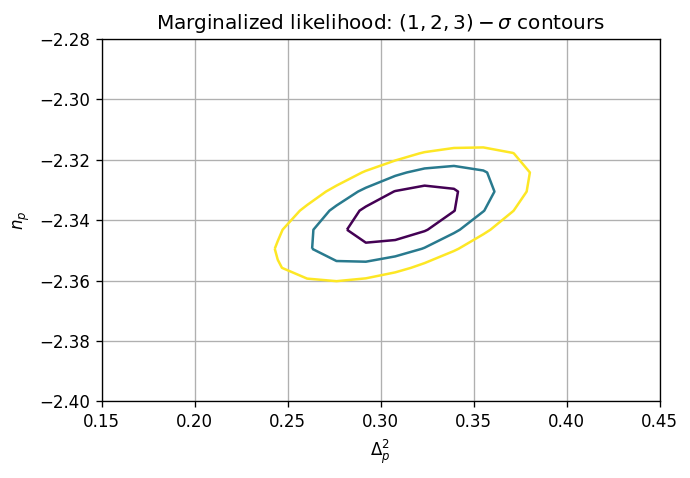

In [10]:
plt.figure()
thresholds = [2.30,6.17,11.8]
plt.contour(DL2_grid,np_grid,-2.0*(loglike_grid-np.max(loglike_grid)),thresholds,label='Chabanier et al. (2019)')
plt.title(r'Marginalized likelihood: $(1,2,3)-\sigma$ contours')
plt.xlabel(r'$\Delta_p^2$')
plt.ylabel(r'$n_p$')
plt.grid() 

### Choose parameter space based on previous Lyman-$\alpha$ work

We will plot here the contours on ($\Delta_p^2$,$n_p$) from McDonald et al. (2005) and Chabanier et al. (2019)

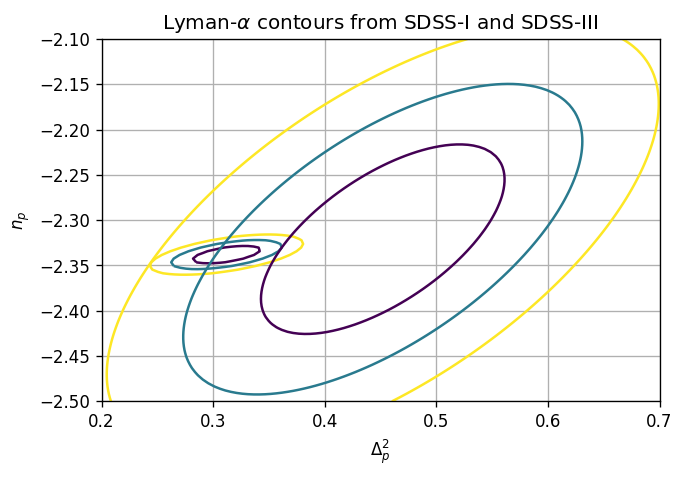

In [11]:
plt.figure()
# create grid (note j in number of elements, crazy python)
#DL2_fine_grid,np_fine_grid = np.mgrid[0.15:0.45:100j,-2.40:-2.28:100j]
DL2_fine_grid,np_fine_grid = np.mgrid[0.20:0.70:100j,-2.50:-2.10:100j]
chi2_fine_grid_2005=lya_results.gaussian_chi2_McDonald2005(np_fine_grid,DL2_fine_grid)
chi2_fine_grid_2019=lya_results.gaussian_chi2_Chabanier2019(np_fine_grid,DL2_fine_grid)

# we will plot the usual contours, equivalent to 1,2,3 sigma in 2D Gaussian
thresholds = [2.30,6.17,11.8]
plt.contour(DL2_fine_grid,np_fine_grid,chi2_fine_grid_2019,thresholds,label='Chabanier et al. (2019)')
plt.contour(DL2_fine_grid,np_fine_grid,chi2_fine_grid_2005,thresholds,label='McDonald et al. (2005)')

plt.title(r'Lyman-$\alpha$ contours from SDSS-I and SDSS-III')
plt.xlabel(r'$\Delta_p^2$')
plt.ylabel(r'$n_p$')
plt.grid() 